# Rainfall maps from CML data
___
<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f07-web.png" alt="drawing" width="1300"/>

Accumulated rainfall for a 48 hour show case from 12 to 14 May 2018 for a) RADOLAN-RW, a gauge ajdusted radar product from the German Weaterh Service and b) CML derived rainfall interpolated using inverse distance weighting [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/).     

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import xarray as xr

import pycomlink as pycml

import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 16}) # Set plot font size to 16pt

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import tqdm

## 1. Process many CMLs

In [10]:
cmls = xr.open_dataset("../data/cml/openMRG_example.nc").isel(sublink_id = 0).load()
cmls

<xarray.Dataset>
Dimensions:       (cml_id: 364, time: 1500)
Coordinates:
    sublink_id    <U9 'sublink_1'
  * cml_id        (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
    site_0_lat    (cml_id) float64 57.7 57.73 57.69 57.71 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 12.0 11.98 11.97 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 57.7 57.72 57.69 57.7 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 11.99 11.97 11.98 11.97 ... 12.14 11.97 11.98
    frequency     (cml_id) float64 2.821e+04 3.853e+04 ... 2.818e+04 2.825e+04
    polarization  (cml_id) object 'v' 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v' 'v'
    length        (cml_id) float64 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
  * time          (time) datetime64[ns] 2015-08-27 ... 2015-08-28T00:59:00
Data variables:
    tsl           (time, cml_id) float32 1.0 0.0 -5.0 -1.0 ... 5.0 12.0 16.0 0.0
    rsl           (time, cml_id) float32 -46.0 -41.0 -39.8 ... -41.3 -40.4 -50.4
Attributes: (12/14)
    title:                 Transformed and resampled OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se, erlend...
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [11]:
# calculate total loss
cmls["tl"] = cmls.tsl - cmls.rsl
# seperate periods of rain from dry time steps
cmls["wet"] = cmls.tl.rolling(time=60, center=True).std(skipna=False) > 0.8
# estiamte the baseline during rain events
cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=cmls.tl,
    wet=cmls.wet,
    n_average_last_dry=5,
)
# compenmsate for wet antenna attenuation
cmls["waa"] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cmls.tl,
    baseline=cmls.baseline,
    wet=cmls.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)
# calculate attenuation caused by rain and remove negative attenuation
cmls["A"] = cmls.tl - cmls.baseline - cmls.waa
cmls["A"].values[cmls.A < 0] = 0
# derive rain rate via the k-R relation
cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cmls.A,
    L_km=cmls.length.astype(float)/1000, # convert to km
    f_GHz=cmls.frequency/1000, # convert to GHz
    pol=cmls.polarization,
)

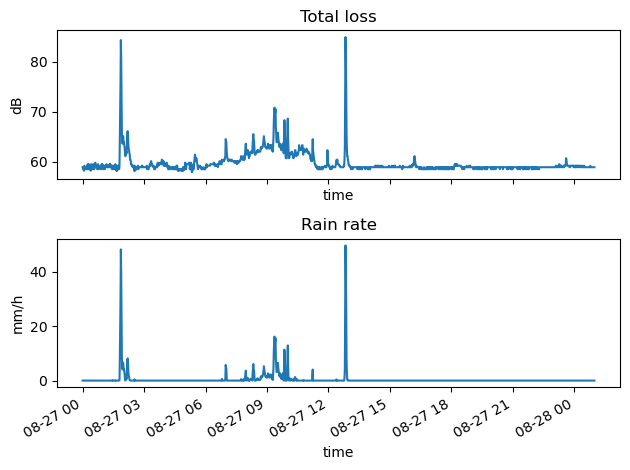

In [12]:
fig,ax = plt.subplots(2,1,sharex=True)
cmls.tl.isel(cml_id=90).plot(ax=ax[0])
ax[0].set_ylabel('dB')
ax[0].set_title('Total loss')
cmls.R.isel(cml_id=90).plot(ax=ax[1])
ax[1].set_ylabel('mm/h')
ax[1].set_title('Rain rate')
plt.tight_layout()

# 2. Interpolate rainfall maps

In [13]:
# beware: 
# - the lat and lon coordinates should be converted to UTM (we skip this part)
# - using the link midpoint is an approximation, more advanced teqniques exists. 

<img src="https://gisgeography.com/wp-content/uploads/2016/05/IDW-3Points.png" alt="drawing" width="600"/>


In [14]:
# define timestep 
time = '2015-08-27T01:55'
# load radar reference data
radar_ref = xr.open_dataset('../data/cml/openMRG_example_rad.nc')

# get the center of each CML
cmls["lat_center"] = (cmls.site_0_lat + cmls.site_1_lat) / 2
cmls["lon_center"] = (cmls.site_0_lon + cmls.site_1_lon) / 2

### 5.1 Inverse distance weighting (IDW)

In [15]:
# define the properties of the IDW algorithm
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15,  # <------------- number of neighbors
    p=2,  # <------------------ weighting parameter
    exclude_nan=True,  # <----- remove nan values from interpolation
    max_distance=0.4,  # <----- upper bound distance
)

In [16]:
# interpolate one hour of rainfall using the lat and lon of the link midpoint. 
R_grid_idw = idw_interpolator(
    x=cmls.lon_center,  # <------------------------- input x coordinates
    y=cmls.lat_center,  # <------------------------- input y coordinates
    z=cmls.R.sel(time=time),  # <----- rainfall values
    xgrid=radar_ref.lon.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.lat.values,  # <--------- target grid y coordinates
)

In [17]:
radar_ref['R_grid_idw'] = (('y', 'x'), R_grid_idw)

### 5.2 Ordinary Kriging

In [18]:
kriging_interpolator = pycml.spatial.interpolator.OrdinaryKrigingInterpolator(
    nlags=6,
    variogram_model='spherical',
    #variogram_parameters=None,
    weight=True,
    n_closest_points=15,
)

In [19]:
R_grid_kriging = kriging_interpolator(
    x=cmls.lon_center.where(~np.isnan(cmls.R.sel(time=time)), drop = True), 
    y=cmls.lat_center.where(~np.isnan(cmls.R.sel(time=time)), drop = True), 
    z=cmls.R.sel(time=time).where(~np.isnan(cmls.R.sel(time=time)), drop = True),  # <----- rainfall values
    xgrid=radar_ref.lon.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.lat.values,  # <--------- target grid y coordinates
)

In [20]:
radar_ref['R_grid_kriging'] = (('y', 'x'), R_grid_kriging)

### Plot IDW and Kriging results

Text(0.5, 1.0, 'radar reference')

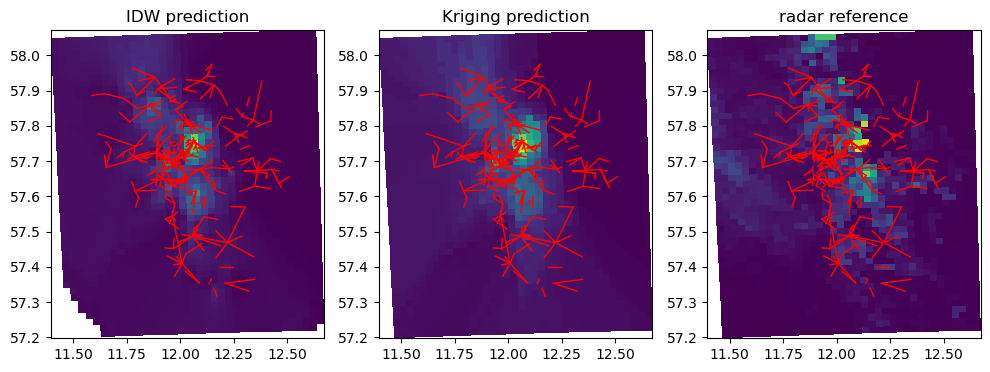

In [21]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))
ax[0].set_title('IDW prediction')
ax[0].pcolormesh(radar_ref.lon.values, radar_ref.lat.values, R_grid_idw)
for cml_i in range(cmls.cml_id.size):
    ax[0].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )    

ax[1].set_title('Kriging prediction')
ax[1].pcolormesh(radar_ref.lon.values, radar_ref.lat.values, radar_ref['R_grid_kriging'])
for cml_i in range(cmls.cml_id.size):
    ax[1].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   

ax[2].pcolormesh(
    radar_ref.lon.values, 
    radar_ref.lat.values, 
    radar_ref.R.sel(time = time, method = 'nearest'),
    #cmap=plt.get_cmap("YlGnBu", 12),
)
for cml_i in range(cmls.cml_id.size):
    ax[2].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   
ax[2].set_title('radar reference');


# Comparing IWD and Kriging to the radar reference

In [22]:
# crop the radar and estimated rainfall fields so that we compare the interpolated pixels
radar_ref_crop = radar_ref.isel(x = slice(10, 30), y = slice(10, 40))

Text(0.5, 1.0, 'radar reference')

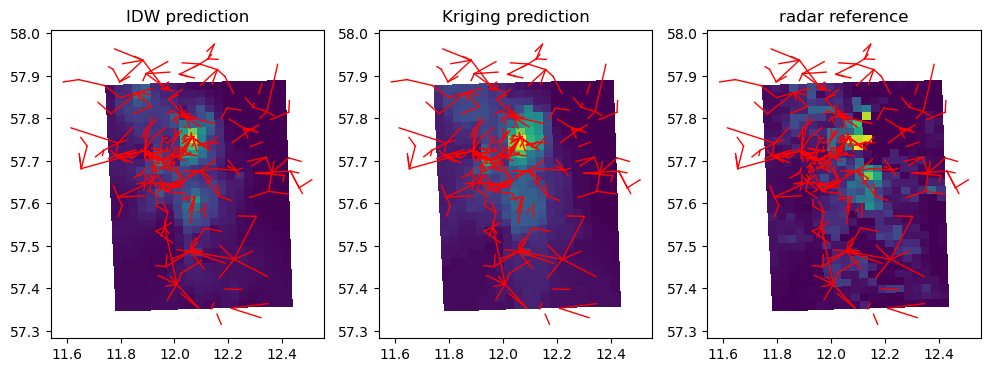

In [23]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))
ax[0].set_title('IDW prediction')
ax[0].pcolormesh(radar_ref_crop.lon.values, radar_ref_crop.lat.values, radar_ref_crop.R_grid_idw)
for cml_i in range(cmls.cml_id.size):
    ax[0].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )    

ax[1].set_title('Kriging prediction')
ax[1].pcolormesh(radar_ref_crop.lon.values, radar_ref_crop.lat.values, radar_ref_crop.R_grid_kriging)
for cml_i in range(cmls.cml_id.size):
    ax[1].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   

ax[2].pcolormesh(
    radar_ref_crop.lon.values, 
    radar_ref_crop.lat.values, 
    radar_ref_crop.R.sel(time = time, method = 'nearest'),
    #cmap=plt.get_cmap("YlGnBu", 12),
)
for cml_i in range(cmls.cml_id.size):
    ax[2].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   
ax[2].set_title('radar reference');


Text(0.5, 1.0, 'Kriging')

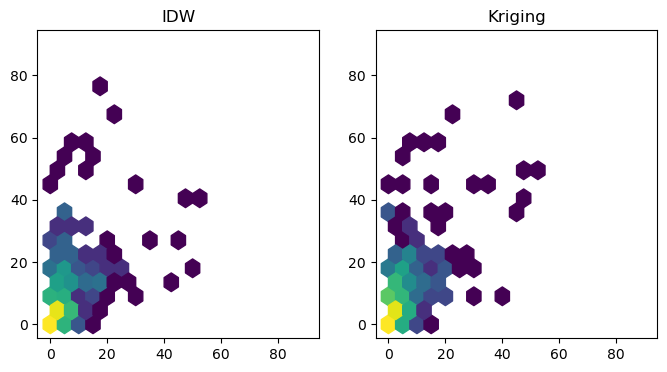

In [24]:
fig, ax = plt.subplots(1, 2, figsize= (8, 4))
ax[0].hexbin(
    radar_ref_crop.R.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_idw.values,
    bins = 'log',
    gridsize = 18,
    extent = (0, 90, 0, 90),

)
ax[0].set_title('IDW')
ax[1].hexbin(
    radar_ref_crop.R.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_kriging.values,
    bins = 'log',
    gridsize = 18,
    extent = (0, 90, 0, 90),
)
ax[1].set_title('Kriging');


# Exercises:

#### Exercise 1
Interpolate and plot another timestep of the dataset and compare it to the reference

#### Exercise 2
Compute and plot an aggregated rainfall map for the time interval '2015-08-27T01:00' -> '2015-08-27T02:00'. Hint: Resample the CML rainfall ammounts using (cmls.R.resample(time = '60T').sum() and radar data using radar_ref.resample(time = '60T').sum(). Then select the timestep of interest. Interpolate the aggregated CML values using IDW or Kriging. Compare the results to the reference using a scatterplot. How does different aggregation times affect the results? 

#### Exercise 3


Draw randomly 40 CMLs from timestep '2015-08-27T01:55'. Interpolate using IDW and Kriging. How does the interpolated maps from IDW and Kriging differ compared to the radar if you include more links? Hint: You can draw random integers by np.random.randint(0, 100, 40) and select them using cmls.isel(cml_id = np.random.randint(0, 100, 40)). 